# Week 10 - Introduction to Modeling

### <font color = 'plum'>  ANSWERS IN THIS COLOR

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score, median_absolute_error, make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from scipy.stats import pearsonr, randint

plt.rcParams['axes.titlesize']  = 10
plt.rcParams['axes.labelsize']  = 8
plt.rcParams['lines.linewidth'] = 0.5
# plt.rcParams['lines.markersize'] = 3
plt.rcParams['axes.edgecolor']  = 'gray'
plt.rcParams['xtick.color']     = 'gray'
plt.rcParams['ytick.color']     = 'gray'
plt.rcParams['xtick.color']     = 'gray'
plt.rcParams['ytick.color']     = 'gray'
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 8

# 1. Lesson

*Apply a random forest model to some training data about stock price changes. The random forest model will predict one of the stocks from the others. You will use cross-validation to perform multiple train-test splits and use grid or random search hyperparameter tuning to choose the number of trees and the maximum depth. In the following week, you will apply this model to your data.*

Last week, we reviewed one model: linear regression.  This week, we are going to review another, called <font color='cyan'>RANDOM FOREST</font>.  The random forest model builds many decision trees, then averages their estimates to make a prediction.

You will also perform:
* Cross-validation
* Hyperparameter tuning
* A performance metric (root mean squared error)

### How does random forest work?

A random forest is a set of decision trees.  Let's say we use `n_estimators = 100` decision trees, and we have ten features.  Then each decision tree is built so that a given branch gets about three (sqrt(10)) features to choose from.  It starts from the top of the tree, selects the best feature, then proceeds to the next nodes.  The best feature is the one that minimizes the mean squared error, which must be computed for both branches, weighted according to the probability of each branch, and then summed over both branches.

Here, we build three series of random numbers between 0 and 1.  We use a somewhat arbitrary formula to construct the synthetic data.  The fourth value (the target) equals the first series minus twice the second, with the whole then being multiplied by the third series.  If we stopped here, the target would be completely dependent on the three feature series - it would be easy to predict.  However, we then add a random normal distribution to make the prediction harder.

There are a training series and a test series, with different features ("a" and "b"), and with different random normal data added.  This tests whether our model can predict new data.  We fit to the "a" features using the train_target, then predict the test_target using the "b" features.

In [2]:
np.random.seed(0)

num_points      = 10000
feature_1a      = np.random.random(size = num_points) * 3
feature_2a      = np.random.random(size = num_points) * 3
feature_3a      = np.random.random(size = num_points) * 3
error_a         = np.random.normal(size = num_points)
train_target    = (feature_1a - 2*feature_2a) * feature_3a + error_a

feature_1b      = np.random.random(size = num_points) * 3
feature_2b      = np.random.random(size = num_points) * 3
feature_3b      = np.random.random(size = num_points) * 3
error_b         = np.random.normal(size = num_points)
test_target     = (feature_1b - 2 * feature_2b) * feature_3b + error_b

train_df        = pd.DataFrame({"f1": feature_1a, "f2": feature_2a, "f3": feature_3a})
test_df         = pd.DataFrame({"f1": feature_1b, "f2": feature_2b, "f3": feature_3b})

# Fit a random forest model to the training data
rf              = RandomForestRegressor().fit(train_df.to_numpy(), train_target)

As expected, the RMSE is smallest when predicting the training data, larger when predicting the testing data, and largest when comparing random (shuffled) data instead of using a prediction.  In the last case, there is no attempt to make a good prediction.  **The small RMSE when predicting the training data indicates that the model has "memorized" the training data to some degree.**

In [3]:
train_preds = rf.predict(train_df.to_numpy())
test_preds  = rf.predict(test_df.to_numpy())

In [4]:
print(f"RMSE when predicting training data: {root_mean_squared_error(train_preds, train_target):.4f}\n")

print(f"RMSE when predicting testing data: {root_mean_squared_error(test_preds, test_target):.4f}\n")

test_target_shuffle = test_target.copy()
np.random.shuffle(test_target_shuffle)

print(f"RMSE with random predictions: {root_mean_squared_error(test_target_shuffle, test_target):.4f}\n")
# print(root_mean_squared_error(test_target_shuffle, test_target))

RMSE when predicting training data: 0.4044

RMSE when predicting testing data: 1.0667

RMSE with random predictions: 5.2621



Next, we perform a Grid Search over various parameters.  We've used a small number of parameters here, but you could add more.  The first parameter, `n_estimators`, shows the number of decision trees in the random forest.  The second, `max_depth`, is the maximum depth of each tree.  By picking three n_estimators values (10, 33, 100) and three max_depth values (2, 4, None), we allow for nine parameter combinations.  For example, (n_estimators = 10, max_depth = 2) is a combination.  The grid search tries all nine combinations and uses cross validation to choose the best one.  This is done below.

### What is cross validation?

Cross validation is a way to find out *which parameter combination is the best*.  With 5-fold cross validation (the default) we divide the data into five equal-sized groups.  Four of them are used as training data and the fifth is testing data.  The score (in this case the root mean squared error) on the testing data is recorded.  This is done for each split: that is, each fifth is taken out and used as testing data; then, the five root mean squared errors (from taking out the five fifths, one at a time) are averaged.

We now have root mean squared error value for each parameter combination, allowing us to choose the best combination.

In [5]:
np.random.seed(0)
gcv = GridSearchCV(estimator    = RandomForestRegressor(), 
                   param_grid   = {"n_estimators": [10, 33, 100],
                                 "max_depth": [2, 4, None]
                                 }, 
                   scoring      = "neg_root_mean_squared_error"
                   )
gcv.fit(train_df.to_numpy(), train_target)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 4, None],
                         'n_estimators': [10, 33, 100]},
             scoring='neg_root_mean_squared_error')

In [6]:
print("GridSearchCV results:\n")
print(f'best_estimator_: {gcv.best_estimator_}\n')
print(f'best_params_: {gcv.best_params_}\n')
print(f'best_score_: {gcv.best_score_}\n')

GridSearchCV results:

best_estimator_: RandomForestRegressor()

best_params_: {'max_depth': None, 'n_estimators': 100}

best_score_: -1.0851316531496098



In [7]:
gcv.cv_results_["mean_test_score"] # There are nine scores, one for each of the 3 x 3 hyperparameter combinations

array([-2.27296628, -2.26369708, -2.26370023, -1.56063403, -1.52732923,
       -1.52615891, -1.12271876, -1.09384603, -1.08513165])

### Why does n_estimators grow like 10, 33, 100 instead of like 1, 50, 100?

First of all, we can make it grow however we want.  The question is why we chose 10, 33, 100.  The idea here is that when you have no idea what is the appropriate number, you should *pick guesses that grow exponentially*.  

For example, suppose you are trying to guess the height of a particular tree.  You look online and find that redwoods grow to 400 feet high, while bonsai trees may be as short as six inches.  If you get three guesses, you could guess: one foot, 200 feet, 400 feet.  These guesses would be linearly spaced out.  However, the 200 foot guess feels wrong - it's still very tall.  Most trees don't grow that tall.  Instead, let's make a *geometric progression:*

In [8]:
list(map(round, [400**0, 400**0.25, 400**0.5, 400**0.75, 400*1]))

[1, 4, 20, 89, 400]

Now the guesses are four feet, 20 feet, and 89 feet.  (We'll drop the initial 1 and the final 400.) That feels more plausible: the middle value, 20 feet, is representative of many actual trees in a way that the middle 200 foot guess wasn't.

# 2. Weekly graph question

In words, please summarize what this graph shows.

In [9]:
rmse_lst = list()
num_points_lst = list()

for x in range(round(num_points / 20), num_points, round(num_points / 20)):
    print(f"Fitting {x} points")
    rf.fit(train_df.to_numpy()[0:x,:], train_target[0:x])
    rmse = root_mean_squared_error(rf.predict(test_df.to_numpy()), test_target)
    print(f"RMSE: {rmse:.4f}\n")
    rmse_lst.append(rmse)
    num_points_lst.append(x)

Fitting 500 points
RMSE: 1.1677

Fitting 1000 points
RMSE: 1.1246

Fitting 1500 points
RMSE: 1.0919

Fitting 2000 points
RMSE: 1.0859

Fitting 2500 points
RMSE: 1.0853

Fitting 3000 points
RMSE: 1.0870

Fitting 3500 points
RMSE: 1.0793

Fitting 4000 points
RMSE: 1.0781

Fitting 4500 points
RMSE: 1.0738

Fitting 5000 points
RMSE: 1.0720

Fitting 5500 points
RMSE: 1.0737

Fitting 6000 points
RMSE: 1.0724

Fitting 6500 points
RMSE: 1.0750

Fitting 7000 points
RMSE: 1.0729

Fitting 7500 points
RMSE: 1.0725

Fitting 8000 points
RMSE: 1.0686

Fitting 8500 points
RMSE: 1.0695

Fitting 9000 points
RMSE: 1.0669

Fitting 9500 points
RMSE: 1.0673



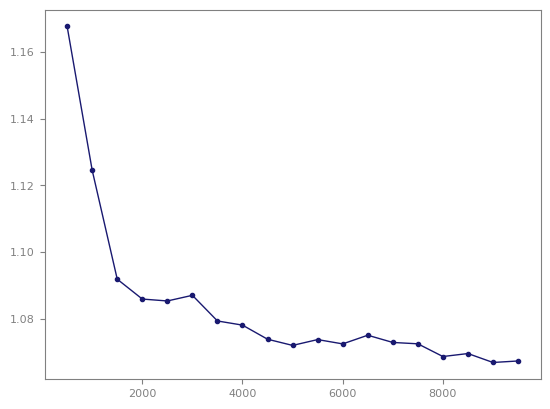

In [10]:
plt.plot(num_points_lst, rmse_lst, marker = 'o', markersize = 3, linewidth = 1, color = 'midnightblue')

<font color = 'plum'> Plots **RMSE (Root Mean Squared Error)** on the **test set** as a function of the number of training samples used to train the `RandomForestRegressor`.

- **X-axis**: Number of training samples (increasing from a small subset up to the full dataset).
- **Y-axis**: RMSE on the test set.

### Patterns

1. **Initial Steep Decline**:
   - When the model is trained on a small number of samples, it performs poorly on the test set, resulting in high RMSE. As more data is added, the model learns better patterns, and RMSE drops quickly.

2. **Diminishing Returns**:
   - After a certain point, adding more training data leads to smaller improvements. As the curve flattens, the model has captured most of the learnable structure in the data.

3. **Asymptotic Behavior**:
   - Eventually, the RMSE stabilizes, approaching the model’s best generalization performance given the noise in the data.


### Addnl Thoughts
- The underlying function generating the target is nonlinear and includes noise.
- Random forests are good at capturing nonlinear relationships, but they still need more data to reduce variance.
- The noise in the target (from `np.random.normal`) sets a lower bound on achievable RMSE.

# 3. Homework

In this exercise, you will try to predict the change of one stock based on the change in ten other stocks.

In [11]:
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

In [12]:
def make_X_y(alpha = 0.5):
    """
    Create feature matrix X with 10 columns corresponding to 10 different stocks.
    Target vector y is the eleventh stock.  
    Stocks have some commonalities: the even numbered stocks are related, as are the odds.  The stocks that are multiples of three are all related, too.
    """

    df_hwk          = pd.DataFrame()
    num_samples_hwk = 10000

    common_odd      = np.random.normal(size = num_samples_hwk)
    common_even     = np.random.normal(size = num_samples_hwk)
    common_three    = np.random.normal(size = num_samples_hwk)

    for n in range(11):
        common = np.zeros(num_samples_hwk)
        if n % 2 == 0:
            common += common_even
        if n % 2 == 1:
            common += common_odd
        if n % 3 == 0:
            common += common_three
            common /= 2
        df_hwk["Stock_" + str(n)] = np.random.normal(size = num_samples_hwk) + alpha * common # y = mx + b, where m = alpha
        
    X = df_hwk.values[:,:-1]
    y = df_hwk.values[:,-1]
    return X, y

The above code creates an X with ten columns, corresponding to ten different stocks.  The **y** is Stock_10, the eleventh stock.  The stocks have some commonalities: the even numbered stocks are related, as are the odds.  The stocks that are multiples of three are all related, too.  

Random forest should be able to sort through all this and decide that the eleventh stock is related to the odd numbered, non-divisible-by-three stocks, and predict accordingly.  The prediction should presumably be, simply, to take Stocks 1, 5, and 7 and average them, as they are odd-numbered and not divisible by three; so perhaps this task would be easier to do with a linear regression, but we'll use a random forest anyway.  

The value `alpha` <font color='cyan'>determines <u>how important the common element is</u>.</font>  If alpha = 0, each stock is its own column of normally-distributed numbers with no relation to the others.  If alpha = 10, then the great majority of the variation in the stock values comes from the common elements.

### Question: Do you predict that alpha = 0 will result in a better or worse prediction than alpha = 10?  

Remember that the prediction must be performed on test data, so you'll need an `X_train` and `y_train` for training and a separate `X_test` and `y_test` for testing.  

I recommend using a correlation rather than a MSE or RMSE in this case, if you want to directly compare two different predictions, because the MSE and RMSE vary with the magnitude of the data as well as with the quality of the prediction.

After you make the prediction, try it out, and comment on what you learned.

#### <font color='plum'> My guess: alpha = 10 will result in better prediction than alpha = 0.
 Alpha = 0 implies that each stock price vector is just independent random noise with no meaningful relationships. Random Forest regressor would have nothing to learn from, so its predictions would be random. 
 
 With alpha = 10, there are strong structural relationships between stocks that RF can capture - specifically that Stock_10 (the target) shares common factors with stocks 1, 5, and 7.

In [13]:
def run_prediction_experiment(alpha_value, scoring_metric = 'explained_variance', grid_search = True):
    """Runs the full experiment for a given alpha, scoring metric, and cross-validation search strategy. Returns a dictionary of results."""

    random_state = 42 
    test_size = 0.2
    verbosity = 1
    # Generate the stock prices and then split into training and testing sets
    X, y = make_X_y(alpha = alpha_value)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = random_state)

    # Instantiate  model and hyperparameter space
    rf = RandomForestRegressor(random_state = random_state)
    param_dist = {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [3, 5, 10],
        'min_samples_split': [2],
        'min_samples_leaf': [1],
        'max_features': ['sqrt', 'log2']  
    }

    # If grid_search is True, use GridSearchCV; otherwise, use RandomizedSearchCV
    if grid_search:
        cv_search = GridSearchCV
        search = cv_search(
            estimator           = rf,
            param_grid         = param_dist,
            # n_iter             = 5,  # Reduced number of iterations for faster execution
            cv                 = 5,
            scoring            = scoring_metric, # Chosen scoring metric
            n_jobs             = -1,
            verbose            = verbosity,
            # random_state       = random_state
    )
    else:
        cv_search = RandomizedSearchCV
        search = cv_search(
            estimator            = rf,
            param_distributions  = param_dist,
            n_iter             = 5,  
            cv                 = 5,
            scoring            = scoring_metric, # Chosen scoring metric
            n_jobs             = -1,
            verbose            = verbosity,
            random_state       = random_state
        )
        
    search.fit(X_train, y_train)

     
    best_model      = search.best_estimator_
    y_pred          = best_model.predict(X_test)
    correlation     = np.corrcoef(y_test, y_pred)[0, 1]

    return {'correlation': correlation, 
            'best_model': best_model, 
            'y_pred': y_pred, 
            'y_test': y_test, 
            'CV_Search': cv_search.__name__
            }


In [14]:
start = time.time()


alphas = [0, 0.1, 0.5, 1, 2, 5, 10]
results = []

for alpha in alphas:
    dict = run_prediction_experiment(alpha_value = alpha, scoring_metric = 'explained_variance', grid_search = True)
    corr = dict['correlation']
    results.append((alpha, corr))
    print(f"{dict['CV_Search']} | Test Set Corr for alpha = {alpha}: {corr:.4f}")

end = time.time()
print(f"Execution time: {format_hms(end - start)}")



Fitting 5 folds for each of 24 candidates, totalling 120 fits
GridSearchCV | Test Set Corr for alpha = 0: 0.0094
Fitting 5 folds for each of 24 candidates, totalling 120 fits
GridSearchCV | Test Set Corr for alpha = 0.1: 0.0322
Fitting 5 folds for each of 24 candidates, totalling 120 fits
GridSearchCV | Test Set Corr for alpha = 0.5: 0.2991
Fitting 5 folds for each of 24 candidates, totalling 120 fits
GridSearchCV | Test Set Corr for alpha = 1: 0.6037
Fitting 5 folds for each of 24 candidates, totalling 120 fits
GridSearchCV | Test Set Corr for alpha = 2: 0.8570
Fitting 5 folds for each of 24 candidates, totalling 120 fits
GridSearchCV | Test Set Corr for alpha = 5: 0.9716
Fitting 5 folds for each of 24 candidates, totalling 120 fits
GridSearchCV | Test Set Corr for alpha = 10: 0.9930
Execution time: 00:02:30


<Figure size 400x300 with 0 Axes>

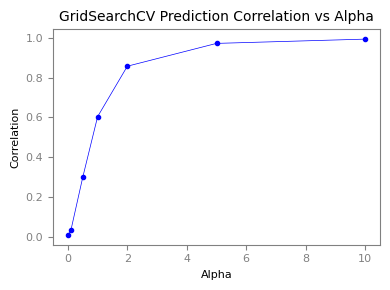

In [15]:
plt.figure(figsize=(4, 3))

# Plot 1: Correlation vs Alpha
plt.figure(figsize=(4, 3))
correlations = [r[1] for r in results]
plt.plot(alphas, correlations, marker='o', markersize=3, linestyle='-', color='blue')
plt.xlabel('Alpha')
plt.ylabel('Correlation')
plt.title('GridSearchCV Prediction Correlation vs Alpha', fontsize=10)
plt.grid(False)

plt.xticks(color='gray')
plt.yticks(color='gray')
plt.tick_params(axis='x', labelsize=8)
plt.tick_params(axis='y', labelsize=8)
plt.tight_layout()
plt.show()

#### <font color='plum'> Result: alpha = 10 performs significantly better than alpha = 0
* alpha = 0: Correlation ≈ 0.001 (essentially random)
* alpha = 10: Correlation ≈ 0.99+ (strong predictive power)

### Randomized Search
Use RandomizedSearchCV instead of GridSearchCV to perform cross-validation.


In [16]:
start = time.time()

# Test different alpha values
alphas = [0, 0.1, 0.5, 1, 2, 5, 10]
results = []

for alpha in alphas:
    dict = run_prediction_experiment(alpha_value=alpha, scoring_metric='explained_variance', grid_search=False)
    corr = dict['correlation']
    results.append((alpha, corr))
    print(f"{dict['CV_Search']} | Test Set Corr for alpha = {alpha}: {corr:.4f}")

end = time.time()
print(f"Execution time: {format_hms(end - start)}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
RandomizedSearchCV | Test Set Corr for alpha = 0: 0.0192
Fitting 5 folds for each of 5 candidates, totalling 25 fits
RandomizedSearchCV | Test Set Corr for alpha = 0.1: 0.0217
Fitting 5 folds for each of 5 candidates, totalling 25 fits
RandomizedSearchCV | Test Set Corr for alpha = 0.5: 0.2843
Fitting 5 folds for each of 5 candidates, totalling 25 fits
RandomizedSearchCV | Test Set Corr for alpha = 1: 0.6307
Fitting 5 folds for each of 5 candidates, totalling 25 fits
RandomizedSearchCV | Test Set Corr for alpha = 2: 0.8556
Fitting 5 folds for each of 5 candidates, totalling 25 fits
RandomizedSearchCV | Test Set Corr for alpha = 5: 0.9752
Fitting 5 folds for each of 5 candidates, totalling 25 fits
RandomizedSearchCV | Test Set Corr for alpha = 10: 0.9929
Execution time: 00:00:39


<Figure size 400x300 with 0 Axes>

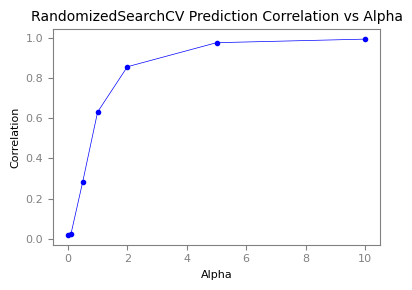

In [17]:
plt.figure(figsize=(4, 3))

# Plot 1: Correlation vs Alpha
plt.figure(figsize=(4, 3))
correlations = [r[1] for r in results]
plt.plot(alphas, correlations, marker='o', markersize=3, linestyle='-', color='blue')
plt.xlabel('Alpha')
plt.ylabel('Correlation')
plt.title('RandomizedSearchCV Prediction Correlation vs Alpha', fontsize=10)
plt.grid(False)

plt.xticks(color='gray')
plt.yticks(color='gray')
plt.tick_params(axis='x', labelsize=8)
plt.tick_params(axis='y', labelsize=8)
plt.tight_layout()
plt.show()

### Scoring

Research the scoring parameters under "regression":

https://scikit-learn.org/dev/modules/model_evaluation.html#scoring-parameter

Choose at least one that you want to learn about, use it, and research it online.  Write something about what you've learned about it.

<font color='plum'>


`Median Absolute Error (MAE)` measures the median of absolute differences between predicted and actual values. Arguably, it's more robust to outliers than Mean Absolute Error,because it uses the median instead of the mean. There's a "negative" prefix, which in sklearn scoring follows the convention that "higher return values are better than lower return values" . Since MAE is an error metric (lower is better), sklearn negates it so that better models have higher scores in cross-validation.

`r2_score`:  The **coefficient of determination** is the proportion of variation in the dependent variable that is predictable from the independent variable(s). In regression, it's the statistical measure of how well the regression predictions approximate the real data points. An R2-squared of 1 indicates that the regression predictions perfectly fit the data.



<font color='plum'>Structural Relationships: 
- With alpha = 10, the common factors create strong structural relationships that Random Forest can capture. Stock_10 (the target) shares common factors with stocks 1, 5, and 7.

Feature Importance: 
- Random Forest successfully identifies the most relevant features. The feature importance analysis would show stocks 1, 5, and 7 as the most important predictors, exactly matching the theoretical expectation.


`RandomizedSearchCV` advantages: 
- Using `RandomizedSearchCV` instead of `GridSearchCV` allows efficient hyperparameter tuning by *sampling from parameter distributions* rather than exhaustively testing all combinations, making it much faster for large parameter spaces.

- The experiment confirms that machine learning models need meaningful signal in the data to make accurate predictions - pure noise yields no predictive power, regardless of model sophistication.

# 4. Storytelling With Data plot

Reproduce any graph of your choice in chapter six (p. 151-163) of the Storytelling With Data book as best you can. You do not have to get the exact data values right, just the overall look and feel.

<font color='plum'>from page 152, Fig. 6.1 of *Storytelling with Data* 

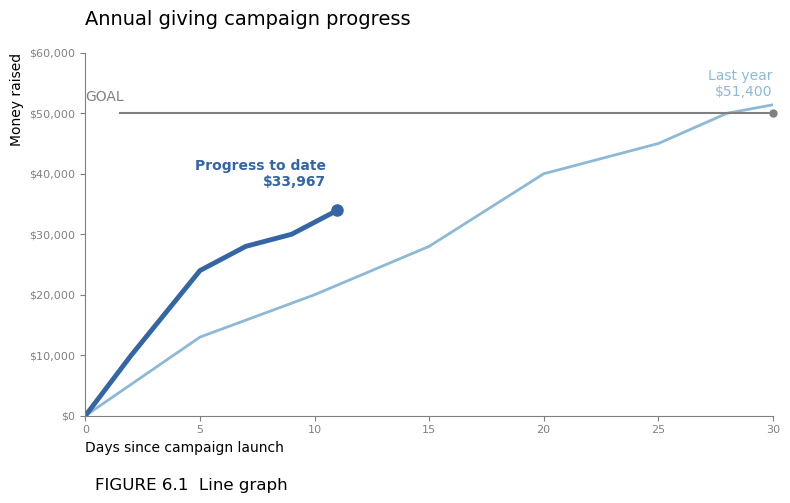

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

# --- 1. Data  ---

days_current = [0, 2, 5, 7, 9, 11]
money_current = [0, 10000, 24000, 28000, 30000, 33967]


days_last_year = [0, 5, 10, 15, 20, 25, 28, 30]
money_last_year = [0, 13000, 20000, 28000, 40000, 45000, 50000, 51400]

goal_amount = 50000

# --- 2. Plot Creation ---
fig, ax = plt.subplots(figsize=(8, 5))
light_blue = "#8db9d6"  # Light blue color for "Last year"
dark_blue = "#3465a4"  # Dark blue color for "Progress to date"
grey = "grey"  # Grey color for "GOAL"

#  "Last year" data (thin light blue line)
ax.plot(days_last_year, money_last_year, color=light_blue, linewidth=2)

#  "Progress to date" data (thick dark blue line)
ax.plot(days_current, money_current, color='#3465a4', linewidth=3.5)
ax.plot(days_current[-1], money_current[-1], 'o', color=dark_blue, markersize=8) # marker at  end of  progress line

#  "GOAL" line (horizontal grey line)
ax.axhline(y=goal_amount, color=grey, linestyle='-', linewidth=1.5, xmin=0.05, xmax=1.0)
ax.plot(30, goal_amount, 'o', color=grey, markersize=5, clip_on=False) # marker at the end of  goal line


# --- 3. Annotations and Labels ---
# Title and Axis Labels
ax.set_title('Annual giving campaign progress', loc='left', fontsize=14, pad=20)
ax.set_xlabel('Days since campaign launch', fontsize=10, loc='left')
ax.set_ylabel('Money raised', fontsize=10, loc='top')

# "Progress to date"
ax.text(days_current[-1] - 0.5, money_current[-1] + 4000, 'Progress to date\n$33,967',
        color=dark_blue, fontsize=10, fontweight='bold', ha='right')

# "Last year"
ax.text(30, money_last_year[-1] + 1500, f'Last year\n${money_last_year[-1]:,}',
        color=light_blue, fontsize=10, ha='right')

# "GOAL"
ax.text(0, goal_amount + 1500, 'GOAL', color=grey, fontsize=10, ha='left', va='bottom')

# Figure caption
fig.text(0.125, 0.01, 'FIGURE 6.1  Line graph', ha='left', fontsize=12)


# --- 4. Styling  ---
# Set axis limits
ax.set_xlim(0, 30)
ax.set_ylim(0, 60000)

#  y-axis ticks dollar signs
formatter = mticker.StrMethodFormatter('${x:,.0f}')
ax.yaxis.set_major_formatter(formatter)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#  tick label size
ax.tick_params(axis='both', which='major', labelsize=8)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()